In [1]:
### imports ###
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 1
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('../report_plots/report.mplstyle')


# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')

PyTorch version: 1.13.1+cu117
Using device: cuda:1


In [2]:
mice_sessions = {'Mouse12': ['120806']}
mouse_id = 'Mouse12'
session_id = '120806'
subset = 'hdc'
phase = 'wake'
bin_size = 160
single_spikes = False
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict_hdc = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                    single_spikes, path=data_dir)

checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
cv_run = -1  # test set is last 1/5 of dataset time series
delay = 0
batch_size = 500  # size of time segments of each batch in dataset below

model_dict_hdc = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict_hdc['neurons'], 
                'max_count': dataset_dict_hdc['max_count'], 
                'bin_size': dataset_dict_hdc['bin_size'], 
                'tbin': dataset_dict_hdc['tbin'], 
                'model_name': dataset_dict_hdc['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-5, 
            }

# model and train/test split based on which validation fold is given by cv_run
modelfit_hdc, _,_,_ = lib.models.load_model(
    checkpoint_dir, model_dict_hdc, dataset_dict_hdc, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)

subset = 'nonhdc'
dataset_dict_nonhdc = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                    single_spikes, path=data_dir)

model_dict = {
                'seed': 123, 
                'll_mode': 'U-ec-3',  # stands for universal count model with exponential-quadratic expansion and C = 3
                'filt_mode': '',  # GLM couplings
                'map_mode': 'svgp-64',  # a sparse variational GP mapping with 64 inducing points
                'x_mode': 'hd-omega-speed-x-y-time',  # observed covariates (behaviour)
                'z_mode': '',  # latent covariates
                'hist_len': 0, 
                'folds': 5, 
                'delays': [0], 
                'neurons': dataset_dict_nonhdc['neurons'], 
                'max_count': dataset_dict_nonhdc['max_count'], 
                'bin_size': dataset_dict_nonhdc['bin_size'], 
                'tbin': dataset_dict_nonhdc['tbin'], 
                'model_name': dataset_dict_nonhdc['name'], 
                'tensor_type': torch.float, 
                'jitter': 1e-5, 
            }

# model and train/test split based on which validation fold is given by cv_run
modelfit_nonhdc, _,_,_ = lib.models.load_model(
    checkpoint_dir, model_dict, dataset_dict_nonhdc, HDC.enc_used, 
    delay, cv_run, batch_size, gpu_dev
)

units:  85  hdc units:  22
units:  85  hdc units:  22


# Figure 6

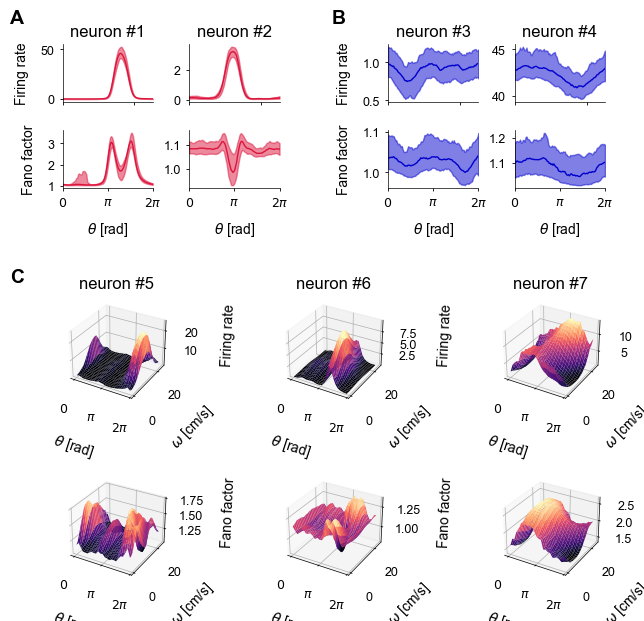

In [6]:
fig = plt.figure(figsize=(7,7), constrained_layout=True)

colors = ['mediumblue', 'crimson']


gs000 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 2], hspace=0.5)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs000[0], wspace=0.5)

hd_sweep = torch.linspace(0, 2*np.pi, 100)
rcov = dataset_dict_hdc['covariates']
rcov = np.empty((0, dataset_dict_hdc['covariates']['hd'].shape[0]))

for cov in ['hd', 'omega', 'speed', 'x', 'y', 'time']:
    rcov = np.concatenate((rcov, dataset_dict_hdc['covariates'][cov][None, :]), axis=0)

covariates = torch.cat([
    hd_sweep[:, None],  # sweep over head direction
    *[rcov[k].mean()*torch.ones((100, 1)) for k in range(1, len(rcov))], 
    # fill other behavioural covariates at value 0
], dim=-1)[None, None, ...]  # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc_hdc = lib.helper.compute_P(
        modelfit_hdc, covariates, list(range(dataset_dict_hdc['neurons'])), MC=30, trials=1)  # predictive posterior
P_mc_hdc = P_mc_hdc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K_hdc = P_mc_hdc.shape[-1]
counts = torch.arange(K_hdc)

hd_mean_hdc = (counts[None, None, None, :] * P_mc_hdc).sum(-1)  # (MC, neurons, steps)
hd_rate_hdc = hd_mean_hdc / dataset_dict_hdc['tbin']  # in units of Hz
hd_var_hdc = (counts[None, None, None, :]**2 * P_mc_hdc).sum(-1) - hd_mean_hdc**2
hd_FF_hdc = hd_var_hdc / (hd_mean_hdc + 1e-12)


with torch.no_grad():
    P_mc_nonhdc = lib.helper.compute_P(
        modelfit_nonhdc, covariates, list(range(dataset_dict_nonhdc['neurons'])), MC=30, trials=1)  # predictive posterior
P_mc_nonhdc = P_mc_nonhdc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K_nonhdc = P_mc_nonhdc.shape[-1]
counts = torch.arange(K_nonhdc)

hd_mean_nonhdc = (counts[None, None, None, :] * P_mc_nonhdc).sum(-1)  # (MC, neurons, steps)
hd_rate_nonhdc = hd_mean_nonhdc / dataset_dict_nonhdc['tbin']  # in units of Hz
hd_var_nonhdc = (counts[None, None, None, :]**2 * P_mc_nonhdc).sum(-1) - hd_mean_nonhdc**2
hd_FF_nonhdc = hd_var_nonhdc / (hd_mean_nonhdc + 1e-12)
for j in range(2):
    gs0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs00[j], wspace=0.4)

    for i, ne in enumerate([5,10]):
        gs = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[i], hspace=0.5) 

        ax = fig.add_subplot(gs[0])


        if j == 0:
            lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate_hdc, [0.05, 0.5, 0.95])
        else:
            lower, mean, upper = utils.signal.percentiles_from_samples(hd_rate_nonhdc, [0.05, 0.5, 0.95])

        line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy(), color=colors[1-j])
        ax.fill_between(
            hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
            color=line.get_color(), alpha=0.5
        )
        if i == 0:
            ax.set_ylabel('Firing rate')
        ax.set_xlim(0, 2*np.pi)
        ax.set_xticklabels([])


        if j ==0:
            ax.set_title(f'neuron #{i+1}')
        else:
            ax.set_title(f'neuron #{i+3}')


        ax = fig.add_subplot(gs[1])

        if j == 0:
            lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF_hdc, [0.05, 0.5, 0.95])
        else:
            lower, mean, upper = utils.signal.percentiles_from_samples(hd_FF_nonhdc, [0.05, 0.5, 0.95])

        line, = ax.plot(hd_sweep.numpy(), mean[ne, :].numpy(), color=colors[1-j])
        ax.fill_between(
            hd_sweep.numpy(), lower[ne, :].numpy(), upper[ne, :].numpy(), 
            color=line.get_color(), alpha=0.5
        )
        if i ==0:
            ax.set_ylabel('Fano factor')
        ax.set_xlabel('$\\theta$ [rad]')
        ax.set_xlim(0, 2*np.pi)
        ax.set_xticks([0, np.pi, 2*np.pi])
        ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])


# 2D search, so there will be steps**2 = 10000 covariate vector inputs

steps = 25
hd_sweep = torch.linspace(0, 2*np.pi, steps)
v_sweep = torch.linspace(np.min(rcov[2]), np.max(rcov[2]), steps)
w_sweep = torch.linspace(np.min(rcov[1]), np.max(rcov[1]), steps)

covariates = torch.cat([
    hd_sweep[:, None].expand(-1, steps).reshape(steps**2, 1),
    rcov[1].mean()*torch.ones((steps**2, 1)),
    v_sweep[None, :].expand(steps, -1).flatten().reshape(steps**2, 1),
    *[rcov[k].mean()*torch.ones((steps**2, 1)) for k in range(3, len(rcov))],
], dim=-1)[None, None, ...] # (tr, neurons, steps, covariate dims)

covariates = torch.cat([
    hd_sweep[:, None].expand(-1, steps).reshape(steps**2, 1),
    w_sweep[None, :].expand(steps, -1).flatten().reshape(steps**2, 1),
    *[rcov[k].mean()*torch.ones((steps**2, 1)) for k in range(2, len(rcov))],
], dim=-1)[None, None, ...] # (tr, neurons, steps, covariate dims)

with torch.no_grad():
    P_mc_hdc = lib.helper.compute_P(
        modelfit_hdc, covariates, list(range(dataset_dict_hdc['neurons'])), MC=30, trials=1)  # predictive posterior
P_mc_hdc = P_mc_hdc.cpu()  # count probabilities of shape (MC, neurons, steps, count)

K = P_mc_hdc.shape[-1]
counts = torch.arange(K)

hd_mean_hdc = (counts[None, None, None, :] * P_mc_hdc).sum(-1)  # (MC, neurons, steps)
hd_rate_hdc = hd_mean_hdc / dataset_dict_hdc['tbin']  # in units of Hz
hd_var_hdc = (counts[None, None, None, :]**2 * P_mc_hdc).sum(-1) - hd_mean_hdc**2
hd_FF_hdc = hd_var_hdc / (hd_mean_hdc + 1e-12)



gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs000[1], wspace=1)

for i, ne in enumerate([3, 14, 20]):

    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[i], hspace=0.6)

    [FF] = utils.signal.percentiles_from_samples(hd_FF_hdc, [0.5])
    [mean] = utils.signal.percentiles_from_samples(hd_rate_hdc, [0.5])

    ax = fig.add_subplot(gs[0], projection='3d')
    # mean has shape (neurons, steps**2), need to unpack it again
    mean = mean.reshape((-1, steps, steps))

    X = np.arange(steps)
    Y = np.arange(steps)
    X, Y = np.meshgrid(X, Y)
    ax.plot_surface(Y, X, mean[ne], cmap='magma', edgecolor='none', linewidth=0)
    
    ax.set_ylabel('$\omega$ [cm/s]')
    ax.set_xlabel('$\\theta$ [rad]')
    ax.set_zlabel('Firing rate')
    ax.set_title(f'neuron #{i+5}')
    ax.set_xticks(np.linspace(0, steps, 3))
    ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

    ax = fig.add_subplot(gs[1], projection='3d')
    FF = FF.reshape((-1, steps, steps))

    ax.plot_surface(Y, X, FF[ne], cmap='magma', edgecolor='none', linewidth=0)
    
    ax.set_ylabel('$\omega $ [cm/s]')
    ax.set_xlabel('$\\theta$ [rad]')
    ax.set_zlabel('Fano factor')
    ax.set_xticks(np.linspace(0, steps, 3))
    ax.set_xticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

fig.text(0.05, 0.91, 'A', transform=fig.transFigure, size=14, fontweight='bold')
fig.text(0.51, 0.91, 'B', transform=fig.transFigure, size=14, fontweight='bold')
fig.text(0.05, 0.54, 'C', transform=fig.transFigure, size=14, fontweight='bold')

plt.show()
fig.savefig("/homes/vn283/UCM-interpret/figures/responses.pdf", format="pdf", bbox_inches="tight")